<a href="https://colab.research.google.com/github/pmandros/tsp_gnn_metalayer_solver/blob/main/TSP_GNN_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Traveling Salesman Problem (TSP) is a classic optimization problem in the field of operations research and computer science. It poses a straightforward yet computationally challenging question: given a list of cities and the distances between each pair of them, what is the shortest possible route that visits each city exactly once and returns to the origin city? Despite its apparent simplicity, the TSP is known for its combinatorial explosion of possible routes as the number of cities increases, making it a quintessential NP-hard problem.

Traditional methods for solving the TSP, such as brute-force search, dynamic programming, and heuristic algorithms, often struggle with scalability and efficiency as the problem size grows. This is where modern approaches, particularly those involving machine learning and neural networks, can offer significant advantages. Machine learning techniques, especially neural networks, have shown promise in addressing the TSP by leveraging their ability to learn and generalize patterns from data. Neural networks could be possibly trained to predict good approximations of optimal routes, significantly reducing computational time compared to traditional exhaustive search methods. Of course, no guarantees about the quality of the solution can be made (at least as of now).

This notebook is a small demonstration of how graph neural networks can be used to solve TSP. In particular, I used the Metalayer technique from https://arxiv.org/abs/1806.01261 implemented by torch-geometric, which is a generalization/abstraction of graph neural networks with traditional fully connected neural neworks.  

I was unaware of the work from Joshi et al. https://arxiv.org/abs/2006.07054 while doing this, but I am very happy to have reached similar conclusions indepedently (and learning some of the terminology). I highly recommend reading this paper to learn more.

In [2]:
pip install torch_geometric

In [1]:
# #this can take a long time. Adjust accordingly for
# import torch

# def format_pytorch_version(version):
#   return version.split('+')[0]

# TORCH_version = torch.__version__
# TORCH = format_pytorch_version(TORCH_version)

# def format_cuda_version(version):
#   return 'cu' + version.replace('.', '')

# CUDA_version = torch.version.cuda
# CUDA = format_cuda_version(CUDA_version)


# !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
# !pip install git+https://github.com/pyg-team/pytorch_geometric.git

# # !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# # !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# # !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# # !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# # !pip install torch-geometric

In [4]:
import numpy as np

import pandas as pd
from typing import Optional, Tuple


import warnings
warnings.filterwarnings("ignore")


In [5]:
# === CÀI & DÙNG python-tsp + ELKAI TRÊN COLAB (1 cell duy nhất) ===
import sys, pkgutil, subprocess, numpy as np

print("Python runtime:", sys.version)
if sys.version_info < (3, 9):
    raise SystemExit(
        "Runtime đang < 3.9 (có thể bạn đã chuyển sang 3.7). "
        "Vào menu Runtime → Restart runtime để quay lại Python mặc định của Colab (3.10+), "
        "rồi chạy lại cell này."
    )

# Cài đúng vào môi trường đang chạy kernel
if pkgutil.find_loader("python_tsp") is None:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "--upgrade", "pip"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "python-tsp>=0.5.0", "elkai"])

# Import sau khi cài
from python_tsp.exact import solve_tsp_dynamic_programming
from python_tsp.heuristics import solve_tsp_local_search
import elkai

def tsp_solution_to_adjacency(permutation, distance=None, distance_matrix=None):
    n = len(permutation)
    A = np.zeros((n, n), dtype=int)
    for i in range(n - 1):
        A[permutation[i], permutation[i + 1]] = 1
    # nối đỉnh cuối về đỉnh đầu THEO THỨ TỰ permutation (sửa lỗi nối về node 0)
    A[permutation[-1], permutation[0]] = 1

    if (distance is not None) and (distance_matrix is not None):
        path_len = float((A * distance_matrix).sum())
        # kiểm chứng tuỳ chọn
        assert np.allclose(path_len, distance, rtol=1e-6, atol=1e-8), (path_len, distance)
    return A

def generate_tsp_data(num_nodes, num_datasets, check_correct=False, exact_limit=22, use_elkai_over=80):
    """
    Trả về: node_coords, distance_matrices, solution_paths, solution_adjacencies, solution_distances
    - n <= exact_limit: dùng dynamic programming (optimal tuyệt đối)
    - exact_limit < n <= use_elkai_over: dùng local-search (nhanh, rất tốt)
    - n > use_elkai_over: dùng ELKAI (Lin–Kernighan), siêu nhanh, gần tối ưu
    """
    node_coords, distance_matrices = [], []
    solution_paths, solution_adjacencies, solution_distances = [], [], []

    for _ in range(num_datasets):
        pts = 100.0 * np.random.rand(num_nodes, 2)
        D = np.sqrt(((pts[:, None, :] - pts[None, :, :]) ** 2).sum(axis=2))

        if num_nodes <= exact_limit:
            perm, dist = solve_tsp_dynamic_programming(D)  # tối ưu tuyệt đối
        elif num_nodes <= use_elkai_over:
            perm, dist = solve_tsp_local_search(D)         # heuristic python-tsp
        else:
            perm = elkai.solve_integer_matrix(D.tolist())  # LK trên ELKAI
            dist = float(sum(D[perm[i], perm[(i+1)%num_nodes]] for i in range(num_nodes)))

        A = tsp_solution_to_adjacency(
            perm,
            distance=dist if check_correct else None,
            distance_matrix=D if check_correct else None,
        )

        node_coords.append(pts)
        distance_matrices.append(D)
        solution_paths.append(perm)
        solution_adjacencies.append(A)
        solution_distances.append(dist)

    return node_coords, distance_matrices, solution_paths, solution_adjacencies, solution_distances



Python runtime: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


The main metric we are interested in for assessing the quality of the solution is the relative gap between the predicted distance versus the actual solution distance. For example, a relative gap close to 0 implies the predicted solution is nearly optimal, while a gap of 0.5 implies the predicted distance is twice as big as the optimal.

Another one we use (just for fun) is the path disagreement, that is, how many nodes are different between solution path and predicted path.

In [6]:
#functions that are useful for assessing quality of solutions

import torch
import numpy as np

def find_greedy_max_neighbor_traversal(weighted_matrix):
    """
    Find the order of traversal starting from the first node as the root
    by greedily selecting the most probable neighbor that is not in the path yet.

    Parameters:
        weighted_matrix (torch.Tensor): Weighted adjacency matrix representing the graph.

    Returns:
        Tensor: Order of traversal starting from the first node.
    """
    # Start traversal from the first node (index 0)
    path = [0]  # Start with the first node
    num_nodes = weighted_matrix.size(0)
    current_node = 0

    # Traverse through the nodes until reaching the last node
    while len(path) < num_nodes:
        # Find the next node (neighbor) with the maximum weight
        max_weight = -float('inf')
        next_node = -1
        for neighbor, weight in enumerate(weighted_matrix[current_node]):
            if neighbor not in path and weight > max_weight:
                max_weight = weight
                next_node = neighbor
        if next_node == -1:
            break  # No valid neighbor found, exit the loop
        else:
            current_node = next_node
            path.append(current_node)

    return torch.Tensor(path)

def count_disagreements(tensor1, tensor2):
    """
    Count the number of positions where two tensors of the same length disagree.

    Parameters:
        tensor1 (torch.Tensor): First tensor.
        tensor2 (torch.Tensor): Second tensor.

    Returns:
        int: Number of positions where the tensors disagree.
    """

    # Ensure both tensors have the same length
    assert tensor1.size() == tensor2.size(), "Tensors must have the same length"

    # Count number of disagreements
    num_disagreements_one_way = (tensor1[1:] != tensor2[1:]).sum().item()
    num_disagreements_other_way = (tensor1[1:] != torch.flip(tensor2[1:], [0])).sum().item()


    return min(num_disagreements_one_way,num_disagreements_other_way)


def mean_per_batch_optimality_metrics(heatmap_pred, heatmap_true, num_graphs, num_nodes, edge_weights, true_distance):
    l1_path_distances = 0
    rel_l1_optimality_gaps = 0
    for i in range(num_graphs):
        solution_path = find_greedy_max_neighbor_traversal(heatmap_pred[i,:,:])
        l1_path_distances += count_disagreements(solution_path,heatmap_true[i,:])

        pred_distance  = sum([edge_weights[i, int(solution_path[j].item()), int(solution_path[j+1].item()) ] for j in range(num_nodes-1)] + [edge_weights[i, int(solution_path[-1].item()),0 ] ])
        rel_l1_optimality_gaps +=  (pred_distance - true_distance[i])/ true_distance[i]
    return l1_path_distances/num_graphs , rel_l1_optimality_gaps/num_graphs

In [6]:
#Creating the data, e.g., in this example, we create 1000 graphs with 10 nodes, 1000 with 15, etc.
#We create graphs with varying number of nodes such that the neural network can learn to generalize.
#Ideally we want many graphs and with many different number of nodes, but that can create computational problems if we lack the resources
#or it the GNN we consider have many parameters.
#Also, the bigger the graph, the more time concorde will need for solving (NP-hard problem)

from torch_geometric.utils import to_undirected,add_self_loops
from torch_geometric.data import Data
import itertools


data_list = []

num_datasets = 500

for num_nodes in [10, 15]:
  node_coords, distance_matrices,solution_paths, solution_adjacencies, distances = generate_tsp_data(num_nodes = num_nodes,  num_datasets = num_datasets, check_correct=True)

  num_pos = num_nodes
  num_neg = num_nodes**2-num_nodes



  weight_pos_class = (num_neg/num_pos)

  edge_index = torch.tensor(list(itertools.product(np.arange(num_nodes),np.arange(num_nodes))), dtype=torch.long).T.contiguous()
  for i in range(len(node_coords)):
      edge_attr = torch.tensor(((distance_matrices[i])).flatten()).float().unsqueeze(1)

      x = torch.tensor(node_coords[i]).float()
      y = torch.tensor(solution_adjacencies[i].flatten()).float().unsqueeze(1)


      data = Data(x=x, edge_index=edge_index, y= y, edge_attr=edge_attr)
      data.edge_weight = torch.tensor(((distance_matrices[i])).flatten()).float().unsqueeze(1)
      data.true_path = torch.Tensor(solution_paths[i])
      data.true_distance = torch.Tensor([distances[i]]).unsqueeze(1)
      data.num_nodes = num_nodes
      data.pos_class_weight = weight_pos_class
      data_list.append(data)

save_path = "tsp_dataset.pt"
torch.save(data_list, save_path)
print(f"Saved {len(data_list)} graphs to {save_path}")

Saved 1000 graphs to tsp_dataset.pt


In [6]:
import torch
data_list = torch.load("tsp_dataset.pt", weights_only=False)
print(len(data_list), type(data_list[0]))

1000 <class 'torch_geometric.data.data.Data'>


In [7]:
#split the data to train, test, val

from torch_geometric.loader import DataLoader
import random

total_length = len(data_list)

# Calculate lengths of each part based on percentages
train_length = int(total_length * 0.7)
val_length = int(total_length * 0.1)

shuffled_list = random.sample(data_list, len(data_list))

# train, validate, test = np.split(data_list, [int(len(data_list)*0.7), int(len(data_list)*0.8)])
train_list = shuffled_list[:train_length]
val_list = shuffled_list[train_length:train_length + val_length]
test_list = shuffled_list[train_length + val_length:]




In [8]:
#to train the GNN with graphs of different sizes, we have to create batches with each batch having graphs of the same size.
#(Not sure there is another way for this)

max_batch_size = 2048  # Maximum batch size
train_batched_data = []

# Sort the datasets based on the number of nodes
sorted_datasets = sorted(train_list, key=lambda x: x.num_nodes)

for dataset in sorted_datasets:
    if not train_batched_data or train_batched_data[-1][-1].num_nodes != dataset.num_nodes:
        # If the current batch is empty or the last dataset in the current batch has a different number of nodes,
        # start a new batch with the current dataset
        train_batched_data.append([dataset])
    else:
        # If adding the current dataset to the last batch doesn't exceed the maximum batch size,
        # add it to the last batch
        current_batch = train_batched_data[-1]
        if sum(data.num_nodes for data in current_batch) + dataset.num_nodes <= max_batch_size:
            current_batch.append(dataset)
        else:
            # Otherwise, start a new batch with the current dataset
            train_batched_data.append([dataset])

print(len(train_batched_data))


5


In [9]:
val_batched_data = []

# Sort the datasets based on the number of nodes
sorted_datasets = sorted(val_list, key=lambda x: x.num_nodes)

for dataset in sorted_datasets:
    if not val_batched_data or val_batched_data[-1][-1].num_nodes != dataset.num_nodes:
        # If the current batch is empty or the last dataset in the current batch has a different number of nodes,
        # start a new batch with the current dataset
        val_batched_data.append([dataset])
    else:
        # If adding the current dataset to the last batch doesn't exceed the maximum batch size,
        # add it to the last batch
        current_batch = val_batched_data[-1]
        if sum(data.num_nodes for data in current_batch) + dataset.num_nodes <= max_batch_size:
            current_batch.append(dataset)
        else:
            # Otherwise, start a new batch with the current dataset
            val_batched_data.append([dataset])



In [10]:
test_batched_data = []

# Sort the datasets based on the number of nodes
sorted_datasets = sorted(test_list, key=lambda x: x.num_nodes)

for dataset in sorted_datasets:
    if not test_batched_data or test_batched_data[-1][-1].num_nodes != dataset.num_nodes:
        # If the current batch is empty or the last dataset in the current batch has a different number of nodes,
        # start a new batch with the current dataset
        test_batched_data.append([dataset])
    else:
        # If adding the current dataset to the last batch doesn't exceed the maximum batch size,
        # add it to the last batch
        current_batch = test_batched_data[-1]
        if sum(data.num_nodes for data in current_batch) + dataset.num_nodes <= max_batch_size:
            current_batch.append(dataset)
        else:
            # Otherwise, start a new batch with the current dataset
            test_batched_data.append([dataset])



In [11]:
#create the data loaders

from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_batched_data, batch_size=None, shuffle=True)
val_loader = DataLoader(val_batched_data, batch_size=None, shuffle=True)
test_loader = DataLoader(test_batched_data, batch_size=None, shuffle=True)




In [ ]:
# #save data

# torch.save(train_loader, 'TSP_1020304050_exact_train.pth')
# torch.save(test_loader, 'TSP_1020304050_exact_test.pth')
# torch.save(val_loader, 'TSP_1020304050_exact_val.pth')

In [ ]:
#load data


# train_loader = torch.load('/content/TSP_58101215/25000_512batch_exact_train.pth')
# test_loader = torch.load( '/content/TSP_58101215/25000_512batch_exact_test.pth')
# val_loader = torch.load( '/content/TSP_58101215/25000_512batch_exact_val.pth')


The Graph Neural Network we consider is based on the Metalayer, which is an generalization of graph neural networks using regular neural networks as opposed to graph layers. In summary, there exists a neural network model for each graph entity, namely nodes, edges, and global. In each step, embeddings are aggregated and concatenated to other entities. We additionally use batch normalization and residual connections. The decoder is a simple inner product (although more options are implemented). Note that in our case we are not using information.

A novelty in our approach is the following. Normally, practical graphs are not fully connected which allows information about nodes and edges to be aggregated from neighboring nodes and edges. In our case, we are using a fully connected graph where edge weights are the distances between the nodes in the TSP (a problem relaxation would be to connect each node only with its closest k neighbors). This means that we have to essentially aggregate over all nodes which can be problematic, e.g., information is being heavily smoothed. For this reason, we perform a weighted aggregation using the Euclidean distances between nodes.

We have two types of initial features. For nodes, we use the 2D coordinates. For edges, we use the edge weights. Both are then mapped to embeddings of fixed hidden size, e.g., 128.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, BatchNorm1d
from torch_geometric.utils import scatter
from torch import Tensor
from typing import Optional, Tuple


class GNN_EdgeModel(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        in_channels = 3 * hidden_dim
        self.edge_mlp = Seq(BatchNorm1d(in_channels),
                            ReLU(),
                            Lin(in_channels, hidden_dim, bias=False))

    def forward(self, src, dst, edge_attr, edge_weight, u, batch):
        out = torch.cat([src, edge_attr, dst], 1)
        return self.edge_mlp(out) + edge_attr


class GNN_NodeModel(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        in_channels = 2 * hidden_dim
        self.node_mlp_1 = Seq(BatchNorm1d(in_channels),
                              ReLU(),
                              Lin(in_channels, hidden_dim))
        self.node_mlp_2 = Seq(BatchNorm1d(in_channels),
                              ReLU(),
                              Lin(in_channels, hidden_dim))

    def forward(self, x, edge_index, edge_attr, edge_weight, u, batch):
        row, col = edge_index
        out = torch.cat([x[row], edge_attr], dim=1)
        out = self.node_mlp_1(out)
        out = scatter(edge_weight.to(x.device) * out, col,
                      dim=0, dim_size=x.size(0), reduce='mean')
        out = torch.cat([x, out], dim=1)
        return self.node_mlp_2(out) + x


class GNN_GlobalModel(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        in_channels = 2 * hidden_dim
        self.global_mlp = Seq(BatchNorm1d(in_channels),
                              ReLU(),
                              Lin(in_channels, hidden_dim, bias=False))

    def forward(self, x, edge_index, edge_attr, u, batch):
        out = torch.cat([u,
                         scatter(x, batch, dim=0, reduce='mean')],
                        dim=1)
        return self.global_mlp(out) + u


class GNN_MetaLayer(nn.Module):
    def __init__(self, edge_model, node_model, global_model):
        super().__init__()
        self.edge_model = edge_model
        self.node_model = node_model
        self.global_model = global_model

    def forward(
        self,
        x: Tensor,
        edge_index: Tensor,
        edge_attr: Optional[Tensor] = None,
        edge_weight: Optional[Tensor] = None,
        u: Optional[Tensor] = None,
        batch: Optional[Tensor] = None,
    ) -> Tuple[Tensor, Optional[Tensor], Optional[Tensor]]:

        row, col = edge_index

        if self.edge_model is not None:
            edge_attr = self.edge_model(x[row], x[col], edge_attr, edge_weight, u,
                                        batch if batch is None else batch[row])

        if self.node_model is not None:
            x = self.node_model(x, edge_index, edge_attr, edge_weight, u, batch)

        if self.global_model is not None:
            u = self.global_model(x, edge_index, edge_attr, u, batch)

        return x, edge_attr, u


class GNN_TSP_SOLVER(nn.Module):
    def __init__(self, node_input_dim, edge_input_dim, hidden_dim,
                 decoder='edge_emb', use_edge_weight=True):
        super().__init__()
        self.lin0_edge = Seq(Lin(edge_input_dim, hidden_dim, bias=False),
                             BatchNorm1d(hidden_dim), ReLU())
        self.lin0_node = Seq(Lin(node_input_dim, hidden_dim, bias=False),
                             BatchNorm1d(hidden_dim), ReLU())

        self.edge_lin1 = Lin(hidden_dim, hidden_dim)
        self.node_lin1 = Lin(hidden_dim * 2, hidden_dim)
        self.nodes_edge_lin1 = Lin(hidden_dim * 3, hidden_dim)
        self.lin2 = Lin(hidden_dim, 1)

        self.decoder = decoder
        self.use_edge_weight = use_edge_weight

        self.metalayer = GNN_MetaLayer(GNN_EdgeModel(hidden_dim),
                                       GNN_NodeModel(hidden_dim),
                                       None)
        self.metalayer2 = GNN_MetaLayer(GNN_EdgeModel(hidden_dim),
                                        GNN_NodeModel(hidden_dim),
                                        None)

    def forward(self, x, edge_index, edge_attr, edge_weight, u, batch):
        edge_attr = self.lin0_edge(edge_attr)
        x = self.lin0_node(x)

        if self.use_edge_weight and edge_weight is not None:
            edge_weight = torch.ones(edge_attr.shape[0], 1,
                                     device=edge_attr.device)

        x, edge_attr, u = self.metalayer(x, edge_index, edge_attr,
                                         edge_weight, None, batch)
        x, edge_attr, u = self.metalayer2(x, edge_index, edge_attr,
                                          edge_weight, None, batch)

        if self.decoder == 'edge_emb':
            out = self.edge_lin1(edge_attr)
        elif self.decoder == 'nodes_emb':
            row, col = edge_index
            z = torch.cat([x[row], x[col]], dim=-1)
            out = self.node_lin1(z)
        elif self.decoder == 'edge_nodes_emb':
            row, col = edge_index
            z = torch.cat([x[row], edge_attr, x[col]], dim=-1)
            out = self.nodes_edge_lin1(z)
        elif self.decoder == 'node_inner_product':
            row, col = edge_index
            out = (x[row] * x[col]).sum(dim=1).unsqueeze(1)
        elif self.decoder == 'cond_node_inner_product':
            row, col = edge_index
            out = x[row]
            out = scatter(edge_weight * out, col, dim=0,
                          dim_size=x.size(0), reduce='mean')
            out = torch.cat([x, out], dim=-1)
            out = (out[row] * out[col]).sum(dim=1).unsqueeze(1)
        else:
            raise ValueError(
                'decoder ∈ {edge_emb, nodes_emb, edge_nodes_emb, '
                'node_inner_product, cond_node_inner_product}'
            )

        if "inner_product" not in self.decoder:
            out = self.lin2(out)

        return out


In [9]:
def train(model, optimizer, train_loader):
    model.train()
    l1_path_distances = 0
    l1_optimality_gaps = 0

    for train_data in train_loader:  # Iterate in batches over the training dataset.
        train_data.x = train_data.x.to(device)
        train_data.edge_index= train_data.edge_index.to(device)
        train_data.edge_attr = train_data.edge_attr.to(device)
        train_data.edge_weight = train_data.edge_weight.to(device)
        train_data.batch = train_data.batch.to(device)
        global_model_x=train_data.pos_class_weight.unsqueeze(1).to(device)
        out = model(train_data.x, train_data.edge_index,train_data.edge_attr, train_data.edge_weight, None, train_data.batch)  # Perform a single forward pass.
        train_loss = criterion(out, train_data.y.to(device))  # Compute the loss.

        batch_weights = torch.ones(train_loss.shape)

        mask = train_data.y.bool()  # Add a dimension to match the shape of ones_tensor
        batch_weights[mask.squeeze()] *= train_data.pos_class_weight[0]

        train_loss = train_loss * batch_weights.to(device)
        train_loss = train_loss.sum() / batch_weights.sum()

        train_loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

        for_view = int(train_data.num_nodes/train_data.num_graphs)
        batch_out_heat_map=out.view((train_data.num_graphs, for_view,for_view))
        batch_truth_heat_map=train_data.true_path.view((train_data.num_graphs, for_view))
        batch_edge_weights=train_data.edge_weight.view((train_data.num_graphs, for_view, for_view))
        batch_true_distancess =  train_data.true_distance.view((train_data.num_graphs))

        l1_path_distance, l1_gap = mean_per_batch_optimality_metrics(batch_out_heat_map, batch_truth_heat_map, train_data.num_graphs,  for_view, batch_edge_weights,batch_true_distancess)
        l1_path_distances += l1_path_distance
        l1_optimality_gaps += l1_gap

    return train_loss, l1_path_distances/len(train_loader), l1_optimality_gaps/len(train_loader)

def test(model, loader):
    model.eval()
    l1_path_distances = 0
    l1_optimality_gaps = 0

    for test_data in loader:  # Iterate in batches over the training dataset.
        test_data.x = test_data.x.to(device)
        test_data.edge_index= test_data.edge_index.to(device)
        test_data.edge_attr = test_data.edge_attr.to(device)
        test_data.edge_weight = test_data.edge_weight.to(device)
        test_data.batch = test_data.batch.to(device)
        global_model_x=test_data.pos_class_weight.unsqueeze(1).to(device)
        out = model(test_data.x, test_data.edge_index,test_data.edge_attr, test_data.edge_weight, test_data.pos_class_weight.unsqueeze(1), test_data.batch)  # Perform a single forward pass.
        test_loss = criterion(out, test_data.y.to(device))  # Compute the loss.


        batch_weights = torch.ones(test_loss.shape).to(device)

        mask = test_data.y.bool()  # Add a dimension to match the shape of ones_tensor
        batch_weights[mask.squeeze()] *= test_data.pos_class_weight[0]

        test_loss = test_loss * batch_weights
        test_loss = test_loss.sum() / batch_weights.sum()


        for_view = int(test_data.num_nodes/test_data.num_graphs)

        batch_out_heat_map=out.view((test_data.num_graphs, for_view, for_view))
        batch_truth_heat_map=test_data.true_path.view((test_data.num_graphs, for_view))
        batch_edge_weights=test_data.edge_weight.view((test_data.num_graphs, for_view, for_view))
        batch_true_distancess =  test_data.true_distance.view((test_data.num_graphs))

        l1_path_distance, l1_gap = mean_per_batch_optimality_metrics(batch_out_heat_map, batch_truth_heat_map, test_data.num_graphs, for_view, batch_edge_weights,batch_true_distancess)
        l1_path_distances += l1_path_distance
        l1_optimality_gaps += l1_gap


    return test_loss, l1_path_distances/len(loader), l1_optimality_gaps/len(loader)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


edge_input_dim = 1
node_input_dim = 2
hidden_dim=128

use_edge_weight = True


num_epochs=30


model = GNN_TSP_SOLVER(node_input_dim,edge_input_dim, hidden_dim, decoder="node_inner_product",use_edge_weight=use_edge_weight)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.00005)

criterion = torch.nn.BCEWithLogitsLoss(reduction='none')

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {pytorch_total_params}')


Number of parameters: 333185


In [100]:
gnn_train_losses = []
gnn_test_losses = []
gnn_val_losses = []

gnn_train_l1_opt_gaps = []
gnn_test_l1_opt_gaps = []
gnn_val_l1_opt_gaps = []

for epoch in range(0, num_epochs+1):
    train_loss, train_l1_path_dist, train_opt_gap = train(model, optimizer, train_loader)
    # we use the validation part also for training
    train_loss, train_l1_path_dist, train_opt_gap = train(model, optimizer, val_loader)

    val_loss, val_l1_path_dist, val_opt_gap  = test(model, val_loader)
    test_loss, test_l1_path_dist, test_opt_gap  = test(model, test_loader)

    if epoch % 5 == 0:
        print(f'Epoch: {(epoch+1):03d}')
        print(f'\t Train loss: {train_loss:.4f} L1 path dist: {train_l1_path_dist:.4f} opt. gap  {train_opt_gap:.4f}')
        print(f'\t Val loss: {val_loss:.4f} L1 path dist: {val_l1_path_dist:.4f} opt. gap  {val_opt_gap:.4f}')
        print(f'\t Test loss: {test_loss:.4f} L1 path dist: {test_l1_path_dist:.4f} opt. gap  {test_opt_gap:.4f}')
        print()

    gnn_train_losses.append(train_loss.item())
    gnn_test_losses.append(test_loss.item())
    gnn_val_losses.append(val_loss.item())

    gnn_train_l1_opt_gaps.append(train_opt_gap.item())
    gnn_test_l1_opt_gaps.append(test_opt_gap.item())
    gnn_val_l1_opt_gaps.append(val_opt_gap.item())


Epoch: 001
	 Train loss: 13.9860 L1 path dist: 8.4068 opt. gap  0.1968
	 Val loss: 59.8479 L1 path dist: 8.5706 opt. gap  0.1654
	 Test loss: 59.8469 L1 path dist: 7.8634 opt. gap  0.1496

Epoch: 006
	 Train loss: 0.9684 L1 path dist: 7.7499 opt. gap  0.1885
	 Val loss: 0.9116 L1 path dist: 6.9980 opt. gap  0.1461
	 Test loss: 0.9158 L1 path dist: 6.9595 opt. gap  0.1370

Epoch: 011
	 Train loss: 0.5551 L1 path dist: 5.8037 opt. gap  0.0515
	 Val loss: 0.6293 L1 path dist: 6.0152 opt. gap  0.0626
	 Test loss: 0.6332 L1 path dist: 6.5325 opt. gap  0.0735

Epoch: 016
	 Train loss: 0.5985 L1 path dist: 5.7195 opt. gap  0.0493
	 Val loss: 0.6025 L1 path dist: 5.4990 opt. gap  0.0500
	 Test loss: 0.5468 L1 path dist: 6.3241 opt. gap  0.0533

Epoch: 021
	 Train loss: 0.5328 L1 path dist: 5.5504 opt. gap  0.0473
	 Val loss: 0.5349 L1 path dist: 5.4288 opt. gap  0.0482
	 Test loss: 0.5966 L1 path dist: 6.1703 opt. gap  0.0509

Epoch: 026
	 Train loss: 0.5302 L1 path dist: 5.3719 opt. gap  0.04

## save result

In [44]:
checkpoint = {
    "epoch": epoch,   # epoch hiện tại (int)
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "results": {
        "gnn_train_losses": gnn_train_losses,
        "gnn_val_losses": gnn_val_losses,
        "gnn_test_losses": gnn_test_losses,
        "gnn_train_l1_opt_gaps": gnn_train_l1_opt_gaps,
        "gnn_val_l1_opt_gaps": gnn_val_l1_opt_gaps,
        "gnn_test_l1_opt_gaps": gnn_test_l1_opt_gaps,
    }
}

torch.save(checkpoint, "gnn_checkpoint.pth")
print("Checkpoint saved to gnn_checkpoint.pth")

Checkpoint saved to gnn_checkpoint.pth


## load result

In [11]:
checkpoint = torch.load("gnn_checkpoint.pth")

# Khởi tạo lại model cùng kiến trúc
model = GNN_TSP_SOLVER(
    node_input_dim=node_input_dim,
    edge_input_dim=edge_input_dim,
    hidden_dim=hidden_dim,
    decoder='edge_emb',
    use_edge_weight=True
)

model.load_state_dict(checkpoint["model_state"])
optimizer.load_state_dict(checkpoint["optimizer_state"])
start_epoch = checkpoint["epoch"] + 1

results = checkpoint["results"]
gnn_train_losses = results["gnn_train_losses"]
gnn_val_losses = results["gnn_val_losses"]
gnn_test_losses = results["gnn_test_losses"]

print(f"Resumed from epoch {checkpoint['epoch']}")

Resumed from epoch 30


# QNN

In [12]:
pip install pennylane

In [12]:
import torch
import torch.nn as nn
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, BatchNorm1d
from torch_geometric.utils import scatter
from torch import Tensor
from typing import Optional, Tuple
import pennylane as qml
import numpy as np

import pandas as pd
from typing import Optional, Tuple


import warnings
warnings.filterwarnings("ignore")


In [13]:
import pennylane as qml

n_qubits = 5
device = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(device, interface="torch")
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    # qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.probs(wires=range(n_qubits))

weight = {"weights": (2, n_qubits, 3)}

In [14]:
def make_quantum_layer(n_qubits: int, n_layers: int = 2, measure: str = "expval",
                       device_name: str = "default.qubit"):
    dev = qml.device(device_name, wires=n_qubits)
    @qml.qnode(dev, interface="torch")
    def circuit(inputs, weights):
        qml.AngleEmbedding(inputs, wires=range(n_qubits))
        qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
        if measure == "probs":
            return qml.probs(wires=range(n_qubits))
        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

    weight_shapes = {"weights": (n_layers, n_qubits, 3)}
    qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)
    out_dim = (2 ** n_qubits) if measure == "probs" else n_qubits
    return qlayer, out_dim

In [15]:
class QuantumBlock(nn.Module):
    """
    Thay thế MLP: ánh xạ in_features -> out_features qua QNN.
    - Adapter trước: Linear(in_features -> n_qubits) (nếu cần)
    - QNN: TorchLayer(expval|probs)
    - Adapter sau: Linear(q_out -> out_features) (nếu cần)
    - Kèm activation (tùy chọn)
    """
    def __init__(self,
                 in_features: int,
                 out_features: int,
                 n_qubits: int | None = None,
                 n_layers: int = 2,
                 measure: str = "expval",
                 activation: nn.Module | None = nn.ReLU()):
        super().__init__()
        if n_qubits is None:
            # Nếu muốn out == hidden_dim như MLP cũ, đặt n_qubits=out_features
            n_qubits = out_features

        # Adapter vào qubit space (nếu in_features != n_qubits)
        self.pre = nn.Identity() if in_features == n_qubits else nn.Linear(in_features, n_qubits, bias=False)

        # QNN
        self.q, q_out = make_quantum_layer(n_qubits=n_qubits, n_layers=n_layers, measure=measure)

        # Adapter về out_features (nếu q_out != out_features)
        self.post = nn.Identity() if q_out == out_features else nn.Linear(q_out, out_features, bias=False)

        self.act = activation

    def forward(self, x):
        x = self.pre(x)
        x = self.q(x)
        x = self.post(x)
        if self.act is not None:
            x = self.act(x)
        return x

In [16]:
class EdgeModel(torch.nn.Module):
    def __init__(self, hidden_dim, q_nqubits: int | None = None, q_layers: int = 2):
        super().__init__()
        in_channels = 3 * hidden_dim
        # MLP cũ:
        # self.edge_mlp = Seq(BatchNorm1d(in_channels), ReLU(), Lin(in_channels, hidden_dim, bias=False))
        # QNN thay thế:
        self.edge_qnn = QuantumBlock(in_features=in_channels,
                                     out_features=hidden_dim,
                                     n_qubits=q_nqubits,      # None -> = hidden_dim; hoặc ví dụ 12/16 để nhẹ hơn
                                     n_layers=q_layers,
                                     measure="expval",
                                     activation=nn.Identity())  # giữ residual ổn định

    def forward(self, src, dst, edge_attr, edge_weight, u, batch):
        out = torch.cat([src, edge_attr, dst], dim=1)    # [E, 3*hidden]
        return self.edge_qnn(out) + edge_attr

In [17]:
class NodeModel(torch.nn.Module):
    def __init__(self, hidden_dim, q_nqubits: int | None = None, q_layers: int = 2):
        super().__init__()
        in1 = 2 * hidden_dim        # concat x[row], edge_attr
        in2 = 2 * hidden_dim        # concat x, aggregated

        # MLP cũ:
        # self.node_mlp_1 = Seq(BatchNorm1d(in1), ReLU(), Lin(in1, hidden_dim))
        # self.node_mlp_2 = Seq(BatchNorm1d(in2), ReLU(), Lin(in2, hidden_dim))

        self.node_qnn_1 = QuantumBlock(in_features=in1,
                                       out_features=hidden_dim,
                                       n_qubits=q_nqubits,
                                       n_layers=q_layers,
                                       measure="expval",
                                       activation=nn.Identity())

        self.node_qnn_2 = QuantumBlock(in_features=in2,
                                       out_features=hidden_dim,
                                       n_qubits=q_nqubits,
                                       n_layers=q_layers,
                                       measure="expval",
                                       activation=nn.Identity())

    def forward(self, x, edge_index, edge_attr, edge_weight, u, batch):
        row, col = edge_index
        out = torch.cat([x[row], edge_attr], dim=1)
        out = self.node_qnn_1(out)

        # lưu ý: nếu dùng device cụ thể, đảm bảo edge_weight và out .to(device) đúng
        out = scatter(edge_weight * out, col, dim=0, dim_size=x.size(0), reduce='mean')

        out = torch.cat([x, out], dim=1)
        return self.node_qnn_2(out) + x

We initialize the solver. We need to be careful with the optimization. We are using graphs of different sizes, with each batch having graphs of same size. We use the binary cross entropy loss and weight each batch with the ratio of solution edges compared to total edges.

In [18]:
class GlobalModel(torch.nn.Module):
    def __init__(self, hidden_dim, q_nqubits: int | None = None, q_layers: int = 2):
        super().__init__()
        in_channels = 2 * hidden_dim
        # self.global_mlp = Seq(BatchNorm1d(in_channels), ReLU(), Lin(in_channels, hidden_dim, bias=False))
        self.global_qnn = QuantumBlock(in_features=in_channels,
                                       out_features=hidden_dim,
                                       n_qubits=q_nqubits,
                                       n_layers=q_layers,
                                       measure="expval",
                                       activation=nn.Identity())

    def forward(self, x, edge_index, edge_attr, u, batch):
        out = torch.cat([u, scatter(x, batch, dim=0, reduce='mean')], dim=1)
        return self.global_qnn(out) + u

In [19]:
class MetaLayer(nn.Module):
    def __init__(self, edge_model, node_model, global_model):
        super(MetaLayer, self).__init__()
        self.edge_model = edge_model
        self.node_model = node_model
        self.global_model = global_model

    def forward(
        self,
        x: Tensor,
        edge_index: Tensor,
        edge_attr: Optional[Tensor] = None,
        edge_weight: Optional[Tensor] = None,
        u: Optional[Tensor] = None,
        batch: Optional[Tensor] = None,
    ) -> Tuple[Tensor, Optional[Tensor], Optional[Tensor]]:
        row = edge_index[0]
        col = edge_index[1]

        if self.edge_model is not None:
            edge_attr = self.edge_model(x[row], x[col], edge_attr, edge_weight, u,
                                        batch if batch is None else batch[row])

        if self.node_model is not None:
            x = self.node_model(x, edge_index, edge_attr, edge_weight, u, batch)

        if self.global_model is not None:
            u = self.global_model(x, edge_index, edge_attr, u, batch)

        return x, edge_attr, u

In [20]:
class METALAYER_TSP_SOLVER(torch.nn.Module):
    def __init__(self, node_input_dim, edge_input_dim, hidden_dim,
                 decoder='edge_emb', use_edge_weight=True,
                 q_front=False, q_hidden_qubits: int | None = None, q_layers: int = 2):
        super().__init__()

        # Frontend encode node/edge raw features -> hidden_dim:
        if q_front:
            # Dùng QNN ngay từ bước encode (nếu muốn)
            self.lin0_edge = QuantumBlock(edge_input_dim, hidden_dim,
                                          n_qubits=q_hidden_qubits, n_layers=q_layers, measure="expval",
                                          activation=nn.ReLU())
            self.lin0_node = QuantumBlock(node_input_dim, hidden_dim,
                                          n_qubits=q_hidden_qubits, n_layers=q_layers, measure="expval",
                                          activation=nn.ReLU())
        else:
            # Encode cổ điển (nhẹ hơn)
            self.lin0_edge = nn.Sequential(nn.Linear(edge_input_dim, hidden_dim, bias=False),
                                           nn.BatchNorm1d(hidden_dim), nn.ReLU())
            self.lin0_node = nn.Sequential(nn.Linear(node_input_dim, hidden_dim, bias=False),
                                           nn.BatchNorm1d(hidden_dim), nn.ReLU())

        # Thay MLP trong metalayer bằng QNN
        self.metalayer = MetaLayer(EdgeModel(hidden_dim, q_nqubits=q_hidden_qubits, q_layers=q_layers),
                                   NodeModel(hidden_dim, q_nqubits=q_hidden_qubits, q_layers=q_layers),
                                   None)
        self.metalayer2 = MetaLayer(EdgeModel(hidden_dim, q_nqubits=q_hidden_qubits, q_layers=q_layers),
                                    NodeModel(hidden_dim, q_nqubits=q_hidden_qubits, q_layers=q_layers),
                                    None)

        self.edge_lin1 = nn.Linear(hidden_dim, hidden_dim)
        self.node_lin1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.nodes_edge_lin1 = nn.Linear(hidden_dim * 3, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, 1)

        self.decoder = decoder
        self.use_edge_weight = use_edge_weight

    def forward(self, x, edge_index, edge_attr, edge_weight, u, batch):
        edge_attr = self.lin0_edge(edge_attr)
        x = self.lin0_node(x)

        if self.use_edge_weight and (edge_weight is not None):
            # nếu muốn “learned” weight, để nguyên; nếu chỉ làm chuẩn hóa thì torch.ones như mã gốc
            edge_weight = torch.ones(edge_attr.shape[0], 1, device=edge_attr.device)

        x, edge_attr, u = self.metalayer(x, edge_index, edge_attr, edge_weight, None, batch)
        x, edge_attr, u = self.metalayer2(x, edge_index, edge_attr, edge_weight, None, batch)

        if self.decoder == 'edge_emb':
            out = self.edge_lin1(edge_attr)
        elif self.decoder == 'nodes_emb':
            row, col = edge_index
            z = torch.cat([x[row], x[col]], dim=-1)
            out = self.node_lin1(z)
        elif self.decoder == 'edge_nodes_emb':
            row, col = edge_index
            z = torch.cat([x[row], edge_attr, x[col]], dim=-1)
            out = self.nodes_edge_lin1(z)
        elif self.decoder == 'node_inner_product':
            row, col = edge_index
            out = (x[row] * x[col]).sum(dim=1).unsqueeze(1)
        elif self.decoder == 'cond_node_inner_product':
            row, col = edge_index
            out = scatter(edge_weight * x[row], col, dim=0, dim_size=x.size(0), reduce='mean')
            out = torch.cat([x, out], dim=-1)
            out = (out[row] * out[col]).sum(dim=1).unsqueeze(1)
        else:
            raise ValueError('decoder ∈ {edge_emb, nodes_emb, edge_nodes_emb, node_inner_product, cond_node_inner_product}')

        if "inner_product" not in self.decoder:
            out = self.lin2(out)
        return out

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


edge_input_dim = 1
node_input_dim = 2
hidden_dim=128

use_edge_weight = True


num_epochs=30


# model = METALAYER_TSP_SOLVER(node_input_dim,edge_input_dim, hidden_dim, decoder="node_inner_product",use_edge_weight=use_edge_weight)
model_qnn = METALAYER_TSP_SOLVER(
    node_input_dim=node_input_dim,   # thay bằng số feature node đầu vào
    edge_input_dim=edge_input_dim,   # thay bằng số feature edge đầu vào
    hidden_dim=hidden_dim,
    decoder='edge_emb',                   # hoặc 'nodes_emb', ...
    use_edge_weight=True,
    q_front=False,                        # True nếu bạn cũng muốn encoder đầu vào là QNN
    q_hidden_qubits=5,                    # số qubit sử dụng
    q_layers=2                            # số layer entangling
)
model_qnn.to(device)

optimizer_qnn = torch.optim.Adam(model_qnn.parameters(), lr=0.002, weight_decay=0.00005)

criterion = torch.nn.BCEWithLogitsLoss(reduction='none')

pytorch_total_params = sum(p.numel() for p in model_qnn.parameters() if p.requires_grad)
print(f'Number of parameters: {pytorch_total_params}')


Number of parameters: 112693


In [97]:
train_losses = []
test_losses = []
val_losses = []

train_l1_opt_gaps = []
test_l1_opt_gaps = []
val_l1_opt_gaps = []

for epoch in range(0, num_epochs+1):
    train_loss, train_l1_path_dist, train_opt_gap = train(model_qnn, optimizer_qnn, train_loader)
    #we use the validation part also for training
    train_loss, train_l1_path_dist, train_opt_gap = train(model_qnn, optimizer_qnn, val_loader)


    val_loss, val_l1_path_dist, val_opt_gap  = test(model_qnn, val_loader)

    test_loss, test_l1_path_dist, test_opt_gap  = test(model_qnn, test_loader)

    if epoch%5 ==0:
        print(f'Epoch: {(epoch+1):03d}')
        print(f'\t Train loss: {train_loss:.4f} L1 path dist: {train_l1_path_dist:.4f} opt. gap  {train_opt_gap:.4f}')
        print(f'\t Val loss: {val_loss:.4f} L1 path dist: {val_l1_path_dist:.4f} opt. gap  {val_opt_gap:.4f}')
        print(f'\t Test loss: {test_loss:.4f} L1 path dist: {test_l1_path_dist:.4f} opt. gap  {test_opt_gap:.4f}')
        print()

    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    val_losses.append(val_loss.item())

    train_l1_opt_gaps.append(train_opt_gap.item())
    test_l1_opt_gaps.append(test_opt_gap.item())
    val_l1_opt_gaps.append(val_opt_gap.item())


Epoch: 001
	 Train loss: 0.5970 L1 path dist: 7.0000 opt. gap  0.1026
	 Val loss: 0.8016 L1 path dist: 7.0992 opt. gap  0.1173
	 Test loss: 0.5506 L1 path dist: 7.3073 opt. gap  0.1192

Epoch: 006
	 Train loss: 0.5250 L1 path dist: 8.0102 opt. gap  0.1986
	 Val loss: 0.5144 L1 path dist: 7.9554 opt. gap  0.1799
	 Test loss: 0.5358 L1 path dist: 7.8874 opt. gap  0.1995



KeyboardInterrupt: 

In [42]:
torch.save(model_qnn.state_dict(), "tsp_model_qnn.pth")
print("Model saved to tsp_model.pth")

Model saved to tsp_model.pth


In [22]:
model_qnn.load_state_dict(torch.load("tsp_model_qnn.pth"))
print("Model loaded from tsp_model.pth")

Model loaded from tsp_model.pth


In [41]:
results = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "test_losses": test_losses,
    "train_l1_opt_gaps": train_l1_opt_gaps,
    "val_l1_opt_gaps": val_l1_opt_gaps,
    "test_l1_opt_gaps": test_l1_opt_gaps,
}

torch.save(results, "qgnn_results.pth")
print("Saved results to gnn_results.pth")

Saved results to gnn_results.pth


In [98]:
import torch

# Load lại dictionary đã lưu
results = torch.load("qgnn_results.pth")

# Gán lại ra từng biến
train_losses       = results["train_losses"]
val_losses         = results["val_losses"]
test_losses        = results["test_losses"]

train_l1_opt_gaps  = results["train_l1_opt_gaps"]
val_l1_opt_gaps    = results["val_l1_opt_gaps"]
test_l1_opt_gaps   = results["test_l1_opt_gaps"]

print("Loaded results successfully!")
print("Train losses length:", len(train_losses))
print("Val losses length:", len(val_losses))
print("Test losses length:", len(test_losses))


Loaded results successfully!
Train losses length: 31
Val losses length: 31
Test losses length: 31


# Convergence result

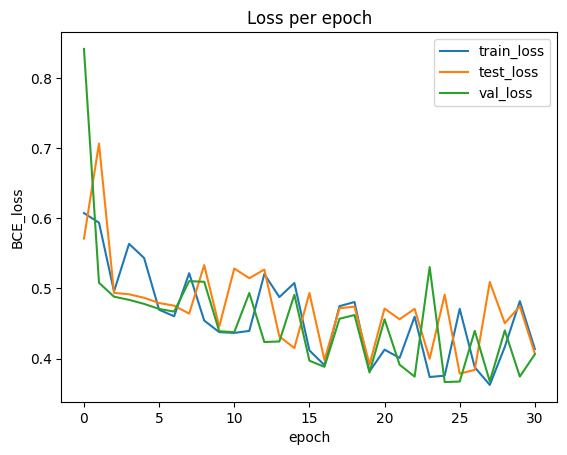

In [46]:
import matplotlib.pyplot as plt
# Plot the curves
plt.plot(train_losses,label='train_loss')
plt.plot(test_losses,label='test_loss')
plt.plot(val_losses,label='val_loss')
plt.xlabel('epoch')
plt.ylabel('BCE_loss')
plt.title('Loss per epoch')
plt.legend()
plt.show()

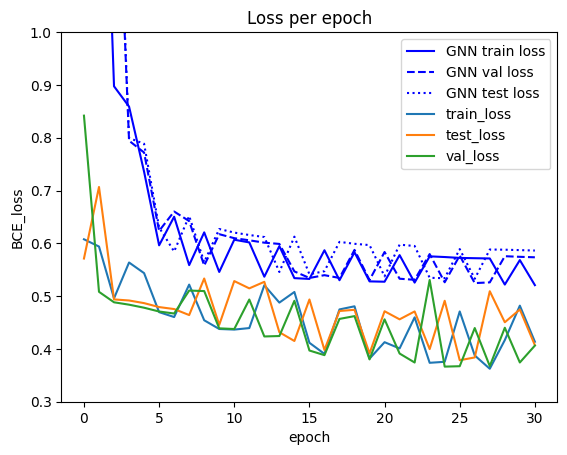

In [48]:
import matplotlib.pyplot as plt
# Plot the curves
#GNN
plt.plot(gnn_train_losses, label='GNN train loss', color='blue', linestyle='-')
plt.plot(gnn_val_losses, label='GNN val loss', color='blue', linestyle='--')
plt.plot(gnn_test_losses, label='GNN test loss', color='blue', linestyle=':')
# QNN
plt.plot(train_losses,label='train_loss')
plt.plot(test_losses,label='test_loss')
plt.plot(val_losses,label='val_loss')


plt.ylim(0.3, 1.0)
plt.xlabel('epoch')
plt.ylabel('BCE_loss')
plt.title('Loss per epoch')
plt.legend()
plt.show()

In [94]:
%%capture
! sudo apt-get update
! sudo apt-get install texlive-latex-recommended
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended
! wget http://mirrors.ctan.org/macros/latex/contr...
! unzip type1cm.zip -d /tmp/type1cm
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm
! sudo texhash
!apt install cm-super

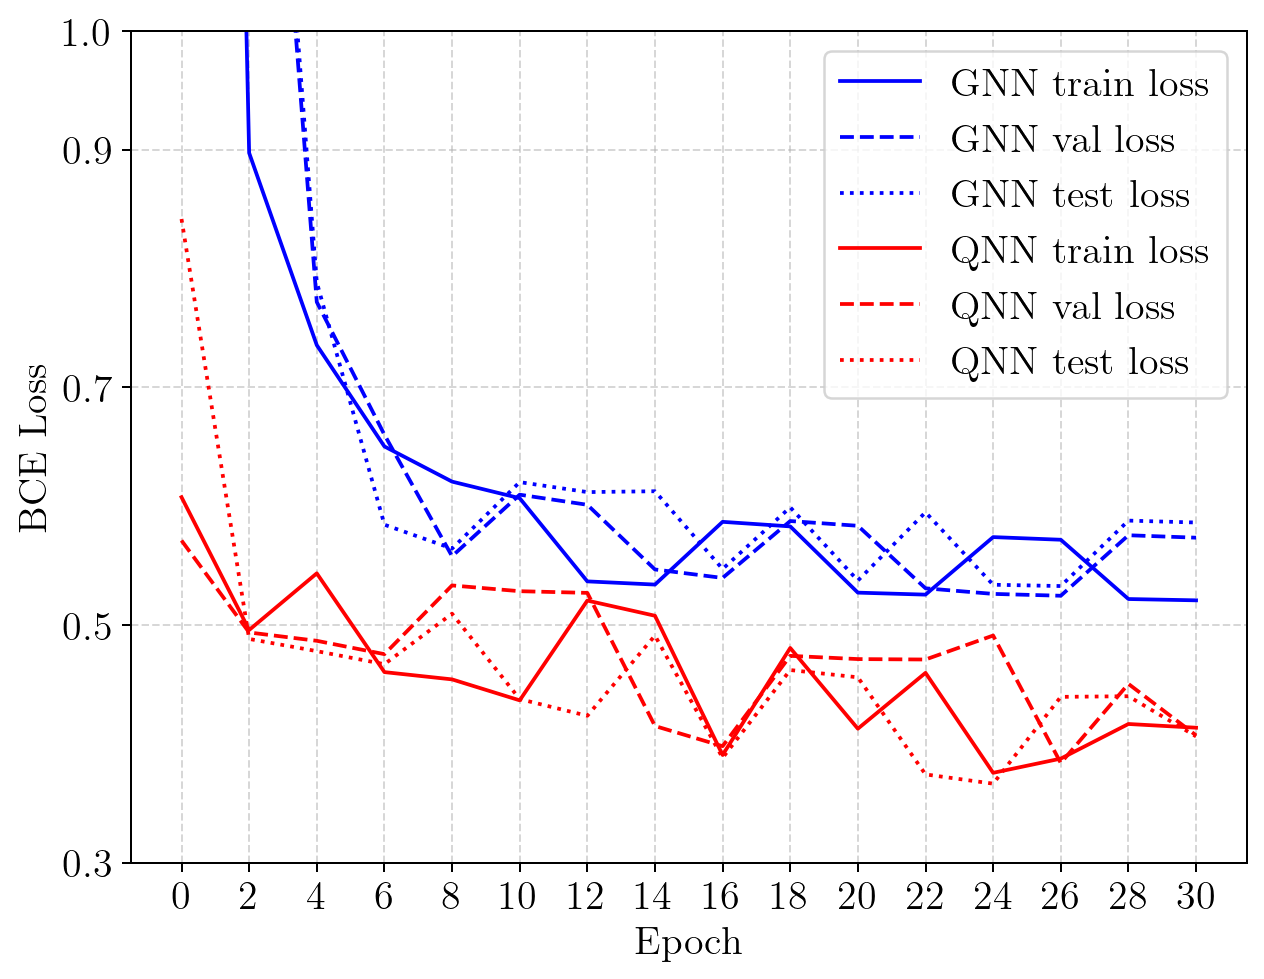

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# đặt bước nhảy ở đây để dễ chỉnh
step = 2

epochs = np.arange(len(gnn_train_losses))

# chỉ lấy theo step
epochs_smooth = epochs[::step]
gnn_train_smooth = gnn_train_losses[::step]
gnn_val_smooth   = gnn_val_losses[::step]
gnn_test_smooth  = gnn_test_losses[::step]

qnn_train_smooth = train_losses[::step]
qnn_val_smooth   = test_losses[::step]
qnn_test_smooth  = val_losses[::step]

plt.rc("text", usetex=True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8, 6), dpi=180)

# --- GNN ---
plt.plot(epochs_smooth, gnn_train_smooth, label='GNN train loss', color='blue', linestyle='-')
plt.plot(epochs_smooth, gnn_val_smooth,   label='GNN val loss',   color='blue', linestyle='--')
plt.plot(epochs_smooth, gnn_test_smooth,  label='GNN test loss',  color='blue', linestyle=':')

# --- QNN ---
plt.plot(epochs_smooth, qnn_train_smooth, label='QNN train loss', color='red', linestyle='-')
plt.plot(epochs_smooth, qnn_val_smooth,   label='QNN val loss',   color='red', linestyle='--')
plt.plot(epochs_smooth, qnn_test_smooth,  label='QNN test loss',  color='red', linestyle=':')

plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
# plt.title(f'Convergence')
plt.ylim(0.3, 1.0)
plt.yticks([0.3, 0.5, 0.7, 0.9, 1.0])
plt.xticks(np.arange(0, len(epochs)+1, step))    # tick trục x theo step
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('loss_per_epoch.pdf')
plt.show()


# Mean relative optimality gap

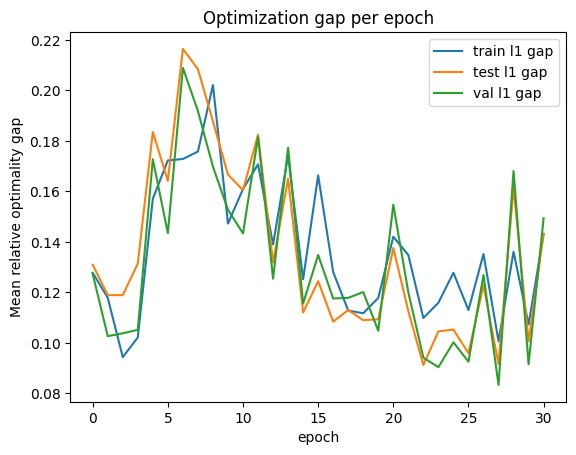

In [33]:
import matplotlib.pyplot as plt
# Plot the curves
plt.plot(train_l1_opt_gaps,label='train l1 gap')
plt.plot(test_l1_opt_gaps,label='test l1 gap')
plt.plot(val_l1_opt_gaps,label='val l1 gap')
plt.xlabel('epoch')
plt.ylabel('Mean relative optimality gap')
plt.title("Optimization gap per epoch")
plt.legend()
plt.show()

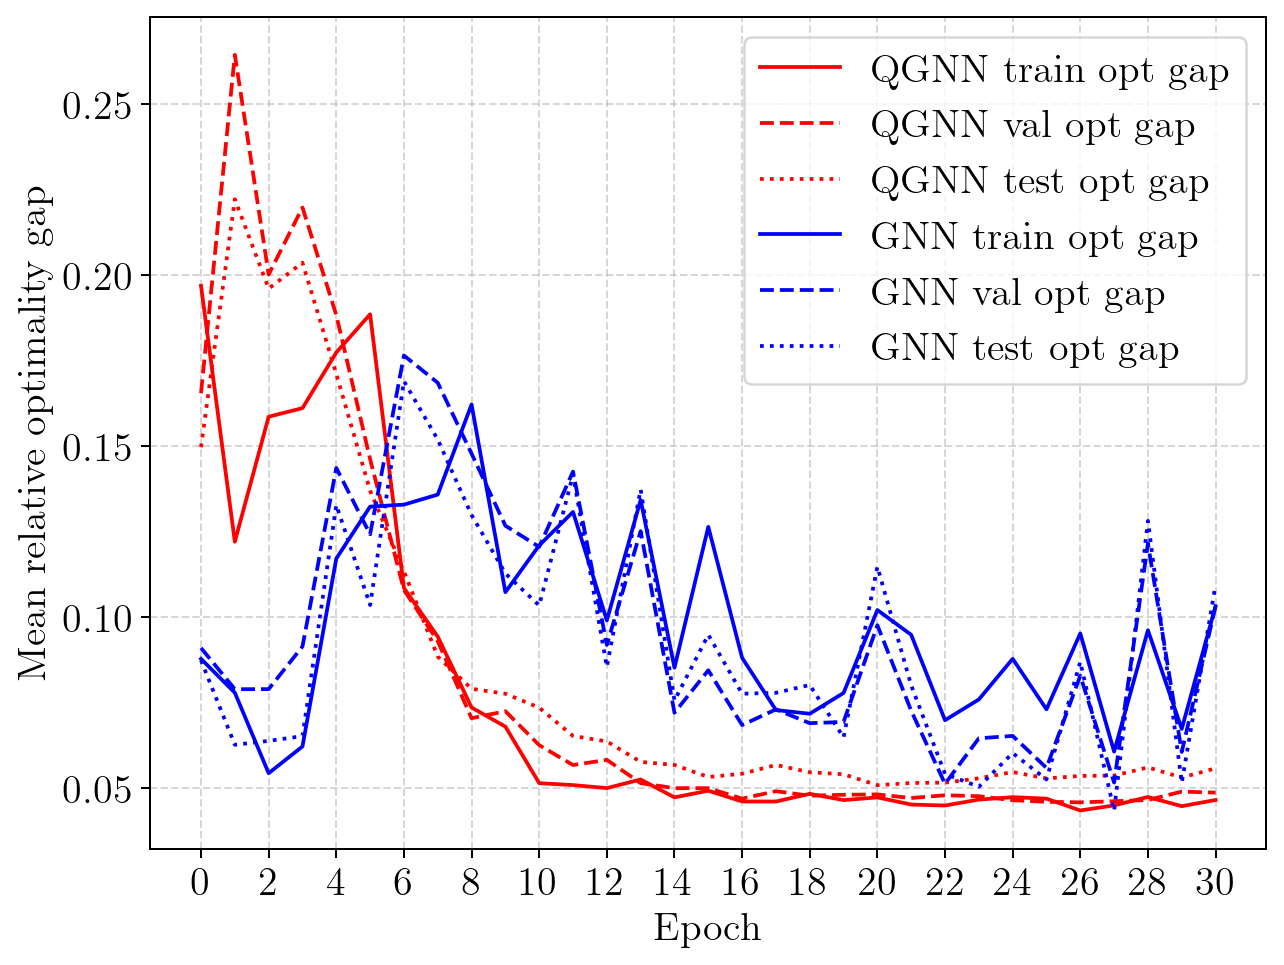

In [115]:
import matplotlib.pyplot as plt
import numpy as np

# đặt step để hiển thị mượt hơn
step = 1
epochs = np.arange(len(gnn_train_l1_opt_gaps))[::step]

# Lấy mẫu theo step
gnn_train = gnn_train_l1_opt_gaps[::step]
gnn_val   = gnn_val_l1_opt_gaps[::step]
gnn_test  = gnn_test_l1_opt_gaps[::step]

qnn_train = train_l1_opt_gaps[::step]
qnn_val   = test_l1_opt_gaps[::step]
qnn_test  = val_l1_opt_gaps[::step]

plt.rc("text", usetex=True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8, 6), dpi=180)

# --- GNN ---
plt.plot(epochs, gnn_train, label='QGNN train opt gap', color='r', linestyle='-')
plt.plot(epochs, gnn_val,   label='QGNN val opt gap',   color='r', linestyle='--')
plt.plot(epochs, gnn_test,  label='QGNN test opt gap',  color='r', linestyle=':')

# --- QNN ---
plt.plot(epochs, qnn_train, label='GNN train opt gap', color='blue', linestyle='-')
plt.plot(epochs, qnn_val,   label='GNN val opt gap',   color='blue', linestyle='--')
plt.plot(epochs, qnn_test,  label='GNN test opt gap',  color='blue', linestyle=':')

plt.xlabel('Epoch')
plt.ylabel('Mean relative optimality gap')
# plt.title(f'Optimization gap per epoch (sampled every {step} epochs)')
# plt.ylim(0.08, 0.22)
# plt.yticks(np.arange(0.3, 1.01, 0.2))
plt.xticks(np.arange(0, len(gnn_train_l1_opt_gaps)+1, 2))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('opt_gap_per_epoch.pdf')
plt.show()


We see the loss having some fluctations. However, the gap decreases somewhat more smoothly. This indicates that our network is learing.

The last test would be to create instances with more nodes than those trained on. Here we create graphs of size 100 nodes. The gap is about 23%, not bad, but not the best either. Many things could be done differnetly, including generating way more training graphs.

# Number of param

In [130]:
import pandas as pd

# --- Đếm tham số GNN ---
gnn_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# --- Đếm tham số QGNN ---
qgnn_total = sum(p.numel() for p in model_qnn.parameters() if p.requires_grad)

# Tách classical vs quantum:
qgnn_quantum = 0
qgnn_classical = 0
for name, param in model_qnn.named_parameters():
    if "qnode" in name or "quantum" in name or "weights" in name:  # tùy theo bạn đặt tên
        qgnn_quantum += param.numel()
    else:
        qgnn_classical += param.numel()

# --- Tạo bảng ---
df = pd.DataFrame([
    {"Model name": "GNN",  "Classical part": gnn_params, "Quantum part": 0, "Total": gnn_params},
    {"Model name": "QGNN", "Classical part": qgnn_classical, "Quantum part": qgnn_quantum, "Total": qgnn_total},
])

print(df)


  Model name  Classical part  Quantum part   Total
0        GNN          333185             0  333185
1       QGNN          112513           180  112693


# Ga

In [109]:
import math
import random
from dataclasses import dataclass
from typing import List, Tuple, Optional, Iterable

import numpy as np
import torch
from torch_geometric.data import Data


# =========================
# Utils
# =========================
def flatten_adj_from_tour(tour: List[int], n: int, directed: bool = True) -> torch.Tensor:
    """
    Biến tour -> vector adjacency flatten size (n*n, 1) giống y trong dataset.
    - directed=True: đặt 1 cho (i->j) theo hướng đi tuần tự trong tour.
    - directed=False: đặt 1 cho cả (i->j) và (j->i) nhằm biểu diễn cạnh không hướng.
    """
    adj = torch.zeros(n, n, dtype=torch.float32)
    for a, b in zip(tour, tour[1:]):
        adj[a, b] = 1.0
        if not directed:
            adj[b, a] = 1.0
    # close the cycle
    adj[tour[-1], tour[0]] = 1.0
    if not directed:
        adj[tour[0], tour[-1]] = 1.0
    # (n*n, 1)
    return adj.reshape(-1, 1)


def edge_attr_to_dist_matrix(edge_attr: torch.Tensor, n: int) -> np.ndarray:
    """
    Dataset của bạn lưu distance_matrices flatten tại edge_attr (E=n*n, 1).
    Hàm này phục dựng thành ma trận NxN (numpy float64).
    """
    assert edge_attr.dim() == 2 and edge_attr.size(0) == n * n
    dm = edge_attr.view(n, n).detach().cpu().numpy().astype(np.float64)
    return dm


def tour_length(tour: List[int], dist: np.ndarray) -> float:
    return sum(dist[tour[i], tour[(i + 1) % len(tour)]] for i in range(len(tour)))


# =========================
# GA Operators
# =========================
def ox_crossover(p1: List[int], p2: List[int]) -> List[int]:
    """
    Ordered Crossover (OX) cho TSP.
    """
    n = len(p1)
    a, b = sorted(random.sample(range(n), 2))
    child = [-1] * n
    # copy đoạn giữa từ p1
    child[a:b+1] = p1[a:b+1]
    # điền phần còn lại theo thứ tự xuất hiện ở p2
    p2_idx = 0
    for i in range(n):
        if child[i] != -1:
            continue
        while p2[p2_idx] in child:
            p2_idx += 1
        child[i] = p2[p2_idx]
    return child


def inversion_mutation(tour: List[int], p: float) -> None:
    """
    Đảo đoạn với xác suất p. In-place.
    """
    if random.random() < p:
        n = len(tour)
        i, j = sorted(random.sample(range(n), 2))
        tour[i:j+1] = reversed(tour[i:j+1])


def swap_mutation(tour: List[int], p: float) -> None:
    if random.random() < p:
        n = len(tour)
        i, j = random.sample(range(n), 2)
        tour[i], tour[j] = tour[j], tour[i]


def two_opt_local_search(tour: List[int], dist: np.ndarray, max_swaps: int = 50) -> List[int]:
    """
    2-opt cải thiện nhanh best tour (giới hạn số lần đổi cạnh).
    """
    n = len(tour)
    best = tour[:]
    best_len = tour_length(best, dist)
    swaps = 0
    improved = True
    while improved and swaps < max_swaps:
        improved = False
        for i in range(1, n - 2):
            for j in range(i + 1, n - 1):
                # candidate bằng cách đảo đoạn [i, j]
                cand = best[:]
                cand[i:j+1] = reversed(cand[i:j+1])
                cand_len = tour_length(cand, dist)
                if cand_len + 1e-12 < best_len:
                    best, best_len = cand, cand_len
                    swaps += 1
                    improved = True
                    if swaps >= max_swaps:
                        break
            if swaps >= max_swaps:
                break
    return best


# =========================
# GA Solver
# =========================
@dataclass
class GASolverConfig:
    population_size: int = 200
    generations: int = 500
    tournament_k: int = 5
    crossover_rate: float = 0.95
    inversion_rate: float = 0.20
    swap_rate: float = 0.05
    elitism: int = 2
    use_two_opt_on_elite: bool = True
    two_opt_max_swaps: int = 50
    early_stop_rounds: int = 50
    seed: Optional[int] = 42


class TSP_GA_Solver:
    def __init__(self, cfg: GASolverConfig):
        self.cfg = cfg
        if cfg.seed is not None:
            random.seed(cfg.seed)
            np.random.seed(cfg.seed)

    def _init_population(self, n: int) -> List[List[int]]:
        base = list(range(n))
        pop = []
        for _ in range(self.cfg.population_size):
            indiv = base[:]
            random.shuffle(indiv)
            pop.append(indiv)
        return pop

    def _fitness(self, tour: List[int], dist: np.ndarray) -> float:
        # minimize length ⇒ fitness = -length
        return -tour_length(tour, dist)

    def _tournament_select(self, pop: List[List[int]], dist: np.ndarray) -> List[int]:
        k = self.cfg.tournament_k
        participants = random.sample(pop, k)
        best = max(participants, key=lambda t: self._fitness(t, dist))
        return best[:]

    def solve(self, dist: np.ndarray) -> Tuple[List[int], float]:
        n = dist.shape[0]
        pop = self._init_population(n)
        fitness = [self._fitness(ind, dist) for ind in pop]

        best = pop[int(np.argmax(fitness))][:]
        best_fit = max(fitness)
        best_len = -best_fit

        no_improve = 0

        for gen in range(self.cfg.generations):
            # Elitism
            elites_idx = np.argsort(fitness)[-self.cfg.elitism:]
            elites = [pop[i][:] for i in elites_idx]

            # Two-opt trên elite (tùy chọn)
            if self.cfg.use_two_opt_on_elite:
                new_elites = []
                for e in elites:
                    improved = two_opt_local_search(e, dist, max_swaps=self.cfg.two_opt_max_swaps)
                    new_elites.append(improved)
                elites = new_elites

            # Cập nhật best
            for e in elites:
                f = self._fitness(e, dist)
                if f > best_fit + 1e-12:
                    best = e[:]
                    best_fit = f
                    best_len = -f

            new_pop: List[List[int]] = elites[:]  # đưa elites vào thế hệ mới

            # Sinh con đến khi đủ population_size
            while len(new_pop) < self.cfg.population_size:
                p1 = self._tournament_select(pop, dist)
                p2 = self._tournament_select(pop, dist)

                # Crossover
                if random.random() < self.cfg.crossover_rate:
                    child = ox_crossover(p1, p2)
                else:
                    child = p1[:]

                # Mutation
                inversion_mutation(child, self.cfg.inversion_rate)
                swap_mutation(child, self.cfg.swap_rate)

                new_pop.append(child)

            pop = new_pop
            fitness = [self._fitness(ind, dist) for ind in pop]

            # Track best
            gen_best_idx = int(np.argmax(fitness))
            gen_best = pop[gen_best_idx]
            gen_best_fit = fitness[gen_best_idx]

            if gen_best_fit > best_fit + 1e-12:
                best = gen_best[:]
                best_fit = gen_best_fit
                best_len = -best_fit
                no_improve = 0
            else:
                no_improve += 1

            # Early stop
            if no_improve >= self.cfg.early_stop_rounds:
                break

        return best, best_len


# =========================
# Batch evaluation trên dataset của bạn
# =========================
@dataclass
class GAEvalResult:
    avg_len: float
    avg_gap_vs_opt: Optional[float]
    edge_f1_directed: Optional[float]
    examples: List[Tuple[int, float, Optional[float]]]


def evaluate_ga_on_dataset(
    data_list: Iterable[Data],
    cfg: GASolverConfig = GASolverConfig(),
    assume_directed_label: bool = True,
) -> GAEvalResult:
    """
    Chạy GA trên từng đồ thị trong data_list.
    - So sánh độ dài tour GA với `true_distance` nếu có.
    - Tính F1 edge (so với y) nếu nhãn tồn tại và cùng kiểu (directed/undirected).
    """
    solver = TSP_GA_Solver(cfg)
    lengths = []
    gaps = []
    f1s = []
    ex = []

    for idx, data in enumerate(data_list):
        n = int(data.num_nodes)
        dist = edge_attr_to_dist_matrix(data.edge_attr, n)

        best_tour, best_len = solver.solve(dist)
        lengths.append(best_len)

        # khoảng cách so với optimum nếu có
        gap = None
        if hasattr(data, "true_distance") and data.true_distance is not None:
            opt = float(data.true_distance.view(-1)[0].item())
            if opt > 0:
                gap = (best_len - opt) / opt
                gaps.append(gap)

        # F1 theo cạnh nếu có y
        f1 = None
        if hasattr(data, "y") and data.y is not None:
            pred_adj = flatten_adj_from_tour(best_tour, n, directed=assume_directed_label).to(data.y.device)
            # y: (n*n,1)
            y_bin = (data.y > 0.5).float()
            tp = (pred_adj * y_bin).sum().item()
            pp = pred_adj.sum().item()
            gp = y_bin.sum().item()
            precision = tp / pp if pp > 0 else 0.0
            recall = tp / gp if gp > 0 else 0.0
            f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0
            f1s.append(f1)

        ex.append((idx, best_len, gap))

    avg_len = float(np.mean(lengths)) if lengths else math.nan
    avg_gap = float(np.mean(gaps)) if gaps else None
    avg_f1 = float(np.mean(f1s)) if f1s else None

    return GAEvalResult(avg_len, avg_gap, avg_f1, ex)


data_list = torch.load("tsp_dataset.pt", weights_only=False)
print(len(data_list), type(data_list[0]))
cfg = GASolverConfig(
    population_size=200,
    generations=500,
    tournament_k=5,
    crossover_rate=0.95,
    inversion_rate=0.20,
    swap_rate=0.05,
    elitism=2,
    use_two_opt_on_elite=True,
    two_opt_max_swaps=50,
    early_stop_rounds=50,
    seed=42,
)

result = evaluate_ga_on_dataset(data_list, cfg, assume_directed_label=True)
print(f"Avg GA tour length: {result.avg_len:.4f}")
if result.avg_gap_vs_opt is not None:
    print(f"Avg relative gap vs. opt: {100*result.avg_gap_vs_opt:.2f}%")
if result.edge_f1_directed is not None:
    print(f"Avg edge F1 (directed): {result.edge_f1_directed:.4f}")
print(f"Evaluated {len(result.examples)} graphs.")


1000 <class 'torch_geometric.data.data.Data'>


KeyboardInterrupt: 

In [23]:
import itertools
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import pandas as pd

# ---------- 1) Build dataset từ generator của bạn ----------
def build_dataset(num_nodes: int, num_datasets: int):
    node_coords, distance_matrices, solution_paths, solution_adjacencies, distances = \
        generate_tsp_data(num_nodes=num_nodes, num_datasets=num_datasets, check_correct=True)

    num_pos = num_nodes
    num_neg = num_nodes**2 - num_nodes
    weight_pos_class = (num_neg / num_pos)

    edge_index = torch.tensor(
        list(itertools.product(np.arange(num_nodes), np.arange(num_nodes))),
        dtype=torch.long
    ).T.contiguous()

    data_list = []
    for i in range(len(node_coords)):
        edge_attr = torch.tensor(distance_matrices[i].reshape(-1, 1)).float()
        x = torch.tensor(node_coords[i]).float()
        y = torch.tensor(solution_adjacencies[i].reshape(-1, 1)).float()

        d = Data(x=x, edge_index=edge_index, y=y, edge_attr=edge_attr)
        d.edge_weight = torch.tensor(distance_matrices[i].reshape(-1, 1)).float()
        d.true_path = torch.tensor(solution_paths[i]).float()
        d.true_distance = torch.tensor([distances[i]]).float().unsqueeze(1)
        d.num_nodes = num_nodes
        d.pos_class_weight = float(weight_pos_class)
        data_list.append(d)
    return data_list

# ---------- 2) Chạy test cho GNN & QGNN trên nhiều kích thước ----------
def evaluate_scenarios_with_test(
    model_gnn,
    model_qgnn,
    sizes=(11, 13, 15),
    num_datasets=10,
    batch_size=128,
    device="cpu"
):
    rows = []
    model.to(device).eval()
    model_qnn.to(device).eval()

    for n in sizes:
        data_list = build_dataset(num_nodes=n, num_datasets=num_datasets)
        loader = DataLoader(data_list, batch_size=batch_size, shuffle=False)

        # test(model, loader) được bạn định nghĩa sẵn: trả (loss, l1_path_dist, opt_gap)
        gnn_loss, gnn_l1, gnn_gap = test(model_gnn, loader)
        q_loss,   q_l1,   q_gap   = test(model_qgnn, loader)

        rows.append({
            "num_nodes": n,
            "GNN_loss": gnn_loss,
            "GNN_L1_path_dist": gnn_l1,
            "GNN_opt_gap": gnn_gap,
            "QGNN_loss": q_loss,
            "QGNN_L1_path_dist": q_l1,
            "QGNN_opt_gap": q_gap,
        })

        print(f"[N={n}]  GNN  -> loss={gnn_loss:.4f}, L1={gnn_l1:.4f}, gap={gnn_gap:.4f}")
        print(f"        QGNN -> loss={q_loss:.4f},  L1={q_l1:.4f},  gap={q_gap:.4f}")

    df = pd.DataFrame(rows, columns=[
        "num_nodes",
        "GNN_loss", "GNN_L1_path_dist", "GNN_opt_gap",
        "QGNN_loss", "QGNN_L1_path_dist", "QGNN_opt_gap",
    ])
    return df

# ---------- 3) Gọi chạy & in bảng ----------
# ví dụ:
# model_gnn = ... (đã khởi tạo & load state_dict)
# model_qgnn = ... (đã khởi tạo & load state_dict)

df_results = evaluate_scenarios_with_test(
    model_gnn=model,
    model_qgnn=model_qnn,
    sizes=[11, 13, 15],
    num_datasets=500,
    batch_size=128,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

print("\nComparison table (test on generated data):")
print(df_results.to_string(index=False))

# (tùy chọn) lưu bảng
df_results.to_csv("gnn_qgnn_compare_10_15_20.csv", index=False)


[N=11]  GNN  -> loss=0.6984, L1=8.0947, gap=0.5110
        QGNN -> loss=0.4397,  L1=5.8100,  gap=0.1252
[N=13]  GNN  -> loss=0.6977, L1=10.1829, gap=0.6459
        QGNN -> loss=0.4248,  L1=7.4505,  gap=0.1508
[N=15]  GNN  -> loss=0.6984, L1=12.0967, gap=0.7495
        QGNN -> loss=0.4056,  L1=9.6339,  gap=0.1932

Comparison table (test on generated data):
 num_nodes                               GNN_loss  GNN_L1_path_dist    GNN_opt_gap                              QGNN_loss  QGNN_L1_path_dist   QGNN_opt_gap
        11 tensor(0.6984, grad_fn=<DivBackward0>)          8.094693 tensor(0.5110) tensor(0.4397, grad_fn=<DivBackward0>)           5.810008 tensor(0.1252)
        13 tensor(0.6977, grad_fn=<DivBackward0>)         10.182920 tensor(0.6459) tensor(0.4248, grad_fn=<DivBackward0>)           7.450498 tensor(0.1508)
        15 tensor(0.6984, grad_fn=<DivBackward0>)         12.096713 tensor(0.7495) tensor(0.4056, grad_fn=<DivBackward0>)           9.633890 tensor(0.1932)


In [24]:
import itertools
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import pandas as pd

# ---------- 1) Build dataset từ generator của bạn ----------
def build_dataset(num_nodes: int, num_datasets: int):
    node_coords, distance_matrices, solution_paths, solution_adjacencies, distances = \
        generate_tsp_data(num_nodes=num_nodes, num_datasets=num_datasets, check_correct=True)

    num_pos = num_nodes
    num_neg = num_nodes**2 - num_nodes
    weight_pos_class = (num_neg / num_pos)

    edge_index = torch.tensor(
        list(itertools.product(np.arange(num_nodes), np.arange(num_nodes))),
        dtype=torch.long
    ).T.contiguous()

    data_list = []
    for i in range(len(node_coords)):
        edge_attr = torch.tensor(distance_matrices[i].reshape(-1, 1)).float()
        x = torch.tensor(node_coords[i]).float()
        y = torch.tensor(solution_adjacencies[i].reshape(-1, 1)).float()

        d = Data(x=x, edge_index=edge_index, y=y, edge_attr=edge_attr)
        d.edge_weight = torch.tensor(distance_matrices[i].reshape(-1, 1)).float()
        d.true_path = torch.tensor(solution_paths[i]).float()
        d.true_distance = torch.tensor([distances[i]]).float().unsqueeze(1)
        d.num_nodes = num_nodes
        d.pos_class_weight = float(weight_pos_class)
        data_list.append(d)
    return data_list

# ---------- 2) Chạy test cho GNN & QGNN trên nhiều kích thước ----------
def evaluate_scenarios_with_test(
    model_gnn,
    model_qgnn,
    sizes=(10, 12, 14),
    num_datasets=10,
    batch_size=128,
    device="cpu"
):
    rows = []
    model.to(device).eval()
    model_qnn.to(device).eval()

    for n in sizes:
        data_list = build_dataset(num_nodes=n, num_datasets=num_datasets)
        loader = DataLoader(data_list, batch_size=batch_size, shuffle=False)

        # test(model, loader) được bạn định nghĩa sẵn: trả (loss, l1_path_dist, opt_gap)
        gnn_loss, gnn_l1, gnn_gap = test(model_gnn, loader)
        q_loss,   q_l1,   q_gap   = test(model_qgnn, loader)

        rows.append({
            "num_nodes": n,
            "GNN_loss": gnn_loss,
            "GNN_L1_path_dist": gnn_l1,
            "GNN_opt_gap": gnn_gap,
            "QGNN_loss": q_loss,
            "QGNN_L1_path_dist": q_l1,
            "QGNN_opt_gap": q_gap,
        })

        print(f"[N={n}]  GNN  -> loss={gnn_loss:.4f}, L1={gnn_l1:.4f}, gap={gnn_gap:.4f}")
        print(f"        QGNN -> loss={q_loss:.4f},  L1={q_l1:.4f},  gap={q_gap:.4f}")

    df = pd.DataFrame(rows, columns=[
        "num_nodes",
        "GNN_loss", "GNN_L1_path_dist", "GNN_opt_gap",
        "QGNN_loss", "QGNN_L1_path_dist", "QGNN_opt_gap",
    ])
    return df

# ---------- 3) Gọi chạy & in bảng ----------
# ví dụ:
# model_gnn = ... (đã khởi tạo & load state_dict)
# model_qgnn = ... (đã khởi tạo & load state_dict)

df_results = evaluate_scenarios_with_test(
    model_gnn=model,
    model_qgnn=model_qnn,
    sizes=[10, 12, 14],
    num_datasets=500,
    batch_size=128,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

print("\nComparison table (test on generated data):")
print(df_results.to_string(index=False))

# (tùy chọn) lưu bảng
df_results.to_csv("gnn_qgnn_compare_10_15_20.csv", index=False)


[N=10]  GNN  -> loss=0.6989, L1=7.1956, gap=0.4774
        QGNN -> loss=0.4437,  L1=4.5997,  gap=0.1013
[N=12]  GNN  -> loss=0.6990, L1=9.1512, gap=0.5609
        QGNN -> loss=0.4250,  L1=6.4390,  gap=0.1361
[N=14]  GNN  -> loss=0.6991, L1=11.1930, gap=0.6890
        QGNN -> loss=0.4206,  L1=8.5982,  gap=0.1697

Comparison table (test on generated data):
 num_nodes                               GNN_loss  GNN_L1_path_dist    GNN_opt_gap                              QGNN_loss  QGNN_L1_path_dist   QGNN_opt_gap
        10 tensor(0.6989, grad_fn=<DivBackward0>)          7.195582 tensor(0.4774) tensor(0.4437, grad_fn=<DivBackward0>)           4.599677 tensor(0.1013)
        12 tensor(0.6990, grad_fn=<DivBackward0>)          9.151199 tensor(0.5609) tensor(0.4250, grad_fn=<DivBackward0>)           6.438982 tensor(0.1361)
        14 tensor(0.6991, grad_fn=<DivBackward0>)         11.193023 tensor(0.6890) tensor(0.4206, grad_fn=<DivBackward0>)           8.598195 tensor(0.1697)
